<h3>
  <center>
    <b><big>Clear View Plus : an Image dehazing approach</big></b><br>
    Work by:<br>
    Souhaiel Ben Salem: souhaiel.ben_salem@ens-paris-saclay.fr<br>
    Maxime Alvarez: maxime.alvarez@ens-paris-saclay.fr<br>
  </center>
</h3>

# Clearview Plus replica

Using the algortihm introduced in this paper : https://openaccess.thecvf.com/content_iccv_2013/papers/Meng_Efficient_Image_Dehazing_2013_ICCV_paper.pdf

## My Implementation (to be simplified) : 

In [1]:
!pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.0 MB/s eta 0:00:00


In [2]:
import torch
import torchvision
import cv2
#from torchvision.models import resnet50 , resnet34
import torch.nn as nn
from torchsummary import summary
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F
from PIL import ImageOps, ImageFilter
import numpy as np
import copy
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode
import matplotlib.pyplot as plt
import pickle
from PIL import Image
from pathlib import Path
import math
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import os
import torch.distributed as dist
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
tsne = TSNE()

**airlight estimation:**

This function estimates the airlight value `A` from the input hazy image. It takes in two arguments: `haze_img` (the input hazy image) and `window_size` (the size of the erosion kernel). 

The function processes each color channel separately if the input image has three channels. It applies erosion using a kernel of the specified window size and then finds the maximum value in the resulting image. The function returns either a single value or a list of values (one for each channel) as the estimated airlight.

In [3]:
def airlight_estimation(haze_img, window_size):
    """Estimates the airlight value of a hazy image.

    Args:
        haze_img (numpy.ndarray): The hazy input image.
        window_size (int): The size of the erosion kernel.

    Returns:
        int: The estimated airlight value.

    """
    A = []
    if len(haze_img.shape) == 3:
        for ch in range(len(haze_img.shape)):
            kernel = np.ones((window_size, window_size), np.uint8)
            min_img = cv2.erode(haze_img[:, :, ch], kernel)
            A.append(int(min_img.max()))
    else:
        kernel = np.ones((window_size, window_size), np.uint8)
        min_img = cv2.erode(haze_img, kernel)
        A.append(int(min_img.max()))
    return A[0] if len(A) == 1 else A


**boundary constraint:**

This function applies the boundary constraint to estimate the transmission map of the input hazy image. It takes in five arguments: `HazeImg` (the input hazy image), `A` (the estimated airlight values), `C0` (the minimum allowed transmission value), `C1` (the maximum allowed transmission value), and `window_size` (the size of the morphology kernel).

 The function computes the transmission map for each color channel separately and then combines them by taking the maximum across channels. It then applies a morphological closing operation using a kernel of the specified window size to refine the estimated transmission map. The function returns the refined transmission map.

In [4]:
def bound_con(HazeImg, A, C0, C1, window_size):
    """Applies the boundary constraint to estimate the transmission map of a hazy image.

    Args:
        HazeImg (numpy.ndarray): The hazy input image.
        A (list): The estimated airlight values.
        C0 (float): The minimum allowed transmission value.
        C1 (float): The maximum allowed transmission value.
        window_size (int): The size of the morphology kernel.

    Returns:
        numpy.ndarray: The estimated transmission map.

    """
    t = np.zeros_like(HazeImg, dtype=np.float32)

    for i in range(3):
        t[:, :, i] = np.maximum((A[i] - HazeImg[:, :, i].astype(np.float32)) / (A[i] - C0),
                                 (HazeImg[:, :, i].astype(np.float32) - A[i]) / (C1 - A[i]))

    t = np.minimum(np.max(t, axis=2), 1.0)

    kernel = np.ones((window_size, window_size), np.float32)
    t = cv2.morphologyEx(t, cv2.MORPH_CLOSE, kernel=kernel)

    return t



**load_filter_bank**:

This function loads a filter bank for edge detection. It returns a list of nine 3x3 filter kernels that can be used for edge detection or feature extraction. The filters include directional edge detection filters as well as a Laplacian filter.

In [5]:
def load_filter_bank():
    """Loads a filter bank for edge detection.

    Returns:
        list: A list of 3x3 filter kernels.

    """
    filters = [
        np.array([[-3, -3, -3], [-3, 0, 5], [-3, 5, 5]]),
        np.array([[-3, -3, -3], [-3, 0, -3], [5, 5, 5]]),
        np.array([[-3, -3, -3], [5, 0, -3], [5, 5, -3]]),
        np.array([[5, -3, -3], [5, 0, -3], [5, -3, -3]]),
        np.array([[5, 5, -3], [5, 0, -3], [-3, -3, -3]]),
        np.array([[5, 5, 5], [-3, 0, -3], [-3, -3, -3]]),
        np.array([[-3, 5, 5], [-3, 0, 5], [-3, -3, -3]]),
        np.array([[-3, -3, 5], [-3, 0, 5], [-3, -3, 5]]),
        np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
    ]
    return filters


**circular convolution:**

This function applies circular convolution with a filter to an input image. It takes in two arguments: `image` (the input image) and `kernel` (the filter kernel).

The function pads the input image with a border that wraps around the image, essentially making it circular. It then applies the filter using the 2D convolution operation and returns the filtered image.

In [6]:
def circular_conv_filt(image, kernel):
    """Applies circular convolution with a filter to an image.

    Args:
        image (numpy.ndarray): The input image.
        kernel (numpy.ndarray): The filter kernel.

    Returns:
        numpy.ndarray: The filtered image.

    """
    kernel_height, kernel_width = kernel.shape
    assert kernel_height == kernel_width, 'Kernel must be square in shape --> Height must be same as width'
    assert kernel_height % 2 == 1, 'Kernel dimension must be an odd number.'

    kernel_half_size = (kernel_height - 1) // 2
    rows, cols = image.shape[:2]
    padded_image = cv2.copyMakeBorder(image, kernel_half_size, kernel_half_size, kernel_half_size, kernel_half_size,
                                       borderType=cv2.BORDER_WRAP)
    filtered_image = cv2.filter2D(padded_image, -1, kernel)
    result = filtered_image[kernel_half_size:rows + kernel_half_size, kernel_half_size:cols + kernel_half_size]
    return result



**weighting function:**

This function calculates the weighting function for a hazy image and a given filter. It takes in three arguments: `hazy_image` (the input hazy image), `filter` (the filter kernel), and `sigma`(the standard deviation of the Gaussian function). 

The function applies the circular convolution operation to each color channel of the hazy image using the provided filter. It then computes the squared distance between the filtered channels and calculates the weighting function using a Gaussian function with the specified standard deviation. The function returns the computed weighting function.

In [7]:
def calculate_weighting_function(hazy_image, filter, sigma = 0.5):
    """Calculates the weighting function for a hazy image and a given filter.

    Args:
        hazy_image (numpy.ndarray): The hazy input image.
        filter (numpy.ndarray): The filter kernel.
        sigma (float): The standard deviation of the Gaussian function.

    Returns:
        numpy.ndarray: The computed weighting function.

    """
    hazy_image = hazy_image.astype(np.float32) / 255.0

    if len(hazy_image.shape) == 3:
        red_channel = hazy_image[:, :, 2]
        green_channel = hazy_image[:, :, 1]
        blue_channel = hazy_image[:, :, 0]

        d_red = circular_conv_filt(red_channel, filter)
        d_green = circular_conv_filt(green_channel, filter)
        d_blue = circular_conv_filt(blue_channel, filter)

        distance_squared = d_red ** 2 + d_green ** 2 + d_blue ** 2
    else:
        distance_squared = circular_conv_filt(hazy_image, filter) ** 2 * 3

    weighting_function = np.exp(-distance_squared / (2 * sigma ** 2))
    return weighting_function


**zero padding:**

This function zero-pads an input image to the specified shape. It takes in three arguments: `image` (the input image), `shape` (the desired output shape of the image), and `position` (the position of the input image in the output one, either 'corner' or 'center').

The function creates a new image with the specified shape, filled with zeros, and then copies the input image into the new image at the specified position. The function returns the zero-padded image.

In [8]:
def zero_pad(image, shape, position='corner'):
    """
    Zero-pads an image to the specified shape.

    Args:
        image (numpy.ndarray): The input image.
        shape (tuple of int): The desired output shape of the image.
        position (str, optional): The position of the input image in the output one. Can be 'corner' (default) or 'center'.

    Returns:
        numpy.ndarray: The zero-padded image.
    """
    shape = np.asarray(shape, dtype=int)
    imshape = np.asarray(image.shape, dtype=int)

    if np.alltrue(imshape == shape):
        return image

    if np.any(shape <= 0):
        raise ValueError("ZERO_PAD: null or negative shape given")

    dshape = shape - imshape
    if np.any(dshape < 0):
        raise ValueError("ZERO_PAD: target size smaller than source one")

    pad_img = np.zeros(shape, dtype=image.dtype)

    idx, idy = np.indices(imshape)

    if position == 'center':
        if np.any(dshape % 2 != 0):
            raise ValueError("ZERO_PAD: source and target shapes have different parity.")
        offx, offy = dshape // 2
    else:
        offx, offy = (0, 0)

    pad_img[idx + offx, idy + offy] = image

    return pad_img


**psf_to_otf**:

This function converts a point-spread function (PSF) to an optical transfer function (OTF). It takes in two arguments: `psf` (the point-spread function array) and `shape` (the output shape of the OTF array). 

The function pads the PSF with zeros, then circularly shifts the values of the PSF array up (or to the left) until the central pixel reaches the (1,1) position. It then computes the Fast Fourier Transform (FFT) of the padded and shifted PSF array to obtain the OTF. This function is useful for frequency-domain filtering and deconvolution tasks.

In [9]:
def psf_to_otf(psf, shape):
    """
    Convert point-spread function to optical transfer function.
    
    Compute the Fast Fourier Transform (FFT) of the point-spread
    function (PSF) array and creates the optical transfer function (OTF)
    array that is not influenced by the PSF off-centering.
    
    By default, the OTF array is the same size as the PSF array. To ensure 
    that the OTF is not altered due to PSF off-centering, this function post-pads 
    the PSF array (down or to the right) with zeros to match dimensions specified in
    shape, then circularly shifts the values of the PSF array up (or to the left) 
    until the central pixel reaches (1,1) position.

    Args:
        psf (numpy.ndarray): The point-spread function (PSF) array.
        shape (int): The output shape of the OTF array.

    Returns:
        numpy.ndarray: The optical transfer function (OTF) array.
    """
    # Check if PSF is all zeros
    if np.all(psf == 0):
        return np.zeros_like(psf)

    inshape = psf.shape
    # Pad the PSF to match shape
    psf = np.pad(psf, [(0, shape[0]-inshape[0]), (0, shape[1]-inshape[1])], mode='constant')

    # Circularly shift OTF so that the 'center' of the PSF is
    # [0,0] element of the array
    for axis, axis_size in enumerate(inshape):
        psf = np.roll(psf, -int(axis_size / 2), axis=axis)

    # Compute the OTF
    otf = np.fft.fft2(psf)

    # Estimate the rough number of operations involved in the FFT
    # and discard the PSF imaginary part if within roundoff error
    # roundoff error = machine epsilon = np.finfo().eps
    n_ops = np.sum(psf.size * np.log2(psf.shape))
    otf = np.real_if_close(otf, tol=n_ops)

    return otf


**transmission map estimation:**

This function estimates the transmission map of a hazy image using a Kirsch filter bank. It takes in three arguments: `haze_img` (the input hazy image), `transmission` (the initial transmission map), and `regularize_lambda` (the regularization parameter).

 The function calculates the weighting functions for all filters in the filter bank and precomputes constants for optimization. Then, it uses a cyclic loop to refine the transmission and optimization variables. The function returns the estimated transmission map.

In [10]:
def cal_transmission(haze_img, transmission, regularize_lambda):
    """Estimates the transmission map of a hazy image using a Kirsch filter bank.

    Args:
        haze_img (numpy.ndarray): The input hazy image.
        transmission (numpy.ndarray): The initial transmission map.
        regularize_lambda (float): The regularization parameter.
        show_haze_transmission_map (bool): Whether to display the haze transmission map.

    Returns:
        numpy.ndarray: The estimated transmission map.

    """
    rows, cols = transmission.shape
    kirsch_filters = [filt / np.linalg.norm(filt) for filt in load_filter_bank()]

    # Calculate weighting functions for all filters
    wf = [calculate_weighting_function(haze_img, filt) for filt in kirsch_filters]

    # Precompute constants for optimization
    t_f = np.fft.fft2(transmission)
    ds = sum(abs(psf_to_otf(filt, (rows, cols)))**2 for filt in kirsch_filters)

    # Cyclic loop for refining t and u (Section III in the paper)
    beta, beta_max, beta_rate = 1, 2**4, 2 * np.sqrt(2)

    while beta < beta_max:
        gamma = regularize_lambda / beta

        # Fix t and solve for u
        du = sum(np.fft.fft2(circular_conv_filt(np.maximum((abs(circular_conv_filt(transmission, filt)) -
                                (wf_i / (len(kirsch_filters) * beta))), 0) *
                              np.sign(circular_conv_filt(transmission, filt)), cv2.flip(filt, -1)))
                 for wf_i, filt in zip(wf, kirsch_filters))

        # Fix u and solve t (Equation 26 in the paper)
        transmission = np.abs(np.fft.ifft2((gamma * t_f + du) / (gamma + ds)))
        beta *= beta_rate

    return transmission

**removing haze:**

This function removes haze from an input image using the estimated transmission and airlight values. It takes in four arguments: `haze_img` (the hazy input image), `transmission` (the estimated transmission map), `airlight` (the estimated airlight values), and `delta` (the fine-tuning parameter for dehazing). 

The function computes the dehazed image by applying the haze removal formula to each color channel of the input image. The function returns the dehazed image.

In [11]:
def remove_haze(haze_img, transmission, airlight, delta=0.85):
    """
    Removes haze from an input image using the estimated transmission and airlight values.

    Args:
        haze_img (numpy.ndarray): The hazy input image.
        transmission (numpy.ndarray): The estimated transmission map.
        airlight (list): The estimated airlight values.
        delta (float, optional): The fine-tuning parameter for dehazing. Default is 0.85.

    Returns:
        numpy.ndarray: The dehazed image.
    """

    epsilon = 0.0001
    transmission = np.power(np.maximum(np.abs(transmission), epsilon), delta)

    haze_corrected_image = np.copy(haze_img)
    if len(haze_img.shape) == 3:
        for ch in range(haze_img.shape[2]):
            temp = ((haze_img[:, :, ch].astype(float) - airlight[ch]) / transmission) + airlight[ch]
            temp = np.maximum(np.minimum(temp, 255), 0)
            haze_corrected_image[:, :, ch] = temp
    else:
        temp = ((haze_img.astype(float) - airlight[0]) / transmission) + airlight[0]
        temp = np.maximum(np.minimum(temp, 255), 0)
        haze_corrected_image = temp

    return haze_corrected_image


## Let's test it

In [80]:
window_size = 15
boundaryConstraint_windowSze = 3
C0 = 20
C1 = 300
regularize_lambda = 0.1
sigma = 0.5
delta = 0.85
transmission=[]

In [61]:
def apply_clear_view(haze_img,delta):
    A = airlight_estimation(haze_img,window_size)
    transmission=bound_con(haze_img, A, C0, C1, window_size=3)
    t=cal_transmission(haze_img, transmission, regularize_lambda=0.1)
    haze_corrected_img = remove_haze(haze_img, t, A, delta=delta)
    HazeTransmissionMap = t
    return (haze_corrected_img, HazeTransmissionMap)

In [62]:
import matplotlib.pyplot as plt

haze_img1 = cv2.imread('/content/what-is-haze.jpg')	
HazeCorrectedImg1, haze_map1 = apply_clear_view(haze_img1,delta=0.65)

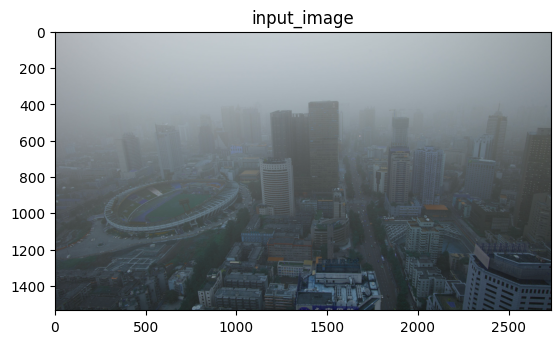

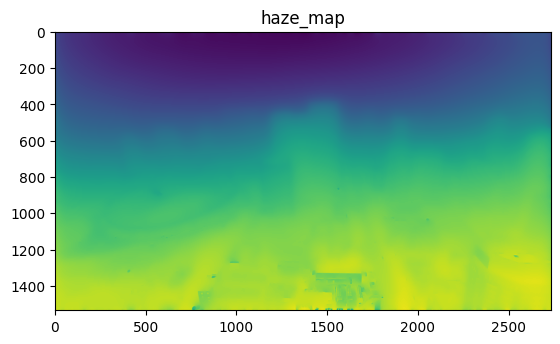

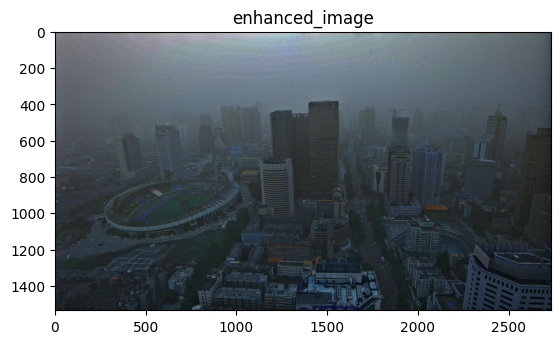

True

In [63]:
plt.imshow(haze_img1)
plt.title('input_image')
plt.show()

plt.imshow(haze_map1)
plt.title('haze_map')
plt.show()

plt.imshow(HazeCorrectedImg1)
plt.title('enhanced_image')
plt.show()

cv2.imwrite("/content/output/dehazed1.png", HazeCorrectedImg1)

In [45]:
import matplotlib.pyplot as plt

haze_img2 = cv2.imread('/content/oxford.jpg')	
HazeCorrectedImg2, haze_map2 = apply_clear_view(haze_img2,delta=0.5)

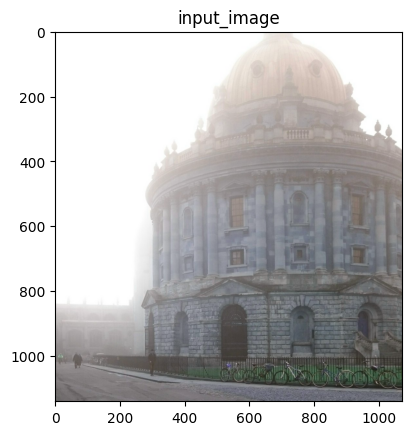

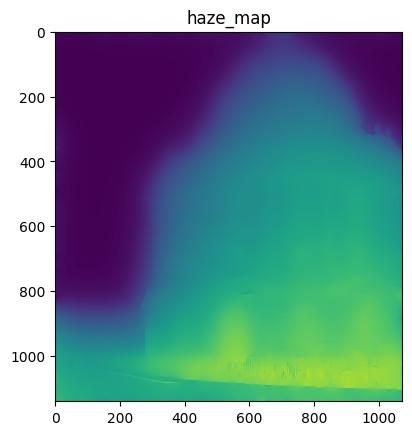

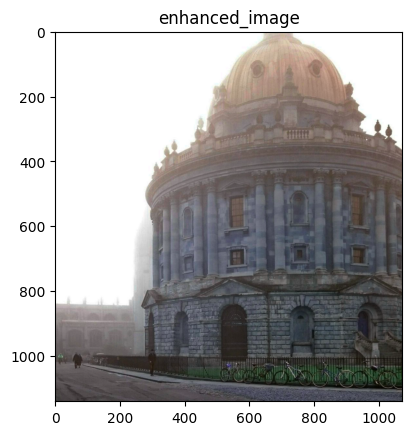

True

In [46]:
plt.imshow(haze_img2)
plt.title('input_image')
plt.show()

plt.imshow(haze_map2)
plt.title('haze_map')
plt.show()

plt.imshow(HazeCorrectedImg2)
plt.title('enhanced_image')
plt.show()

cv2.imwrite("/content/output/dehazed2.png", HazeCorrectedImg2)

In [47]:
import matplotlib.pyplot as plt

haze_img3 = cv2.imread('/content/dxo_pic1.jpg')	
HazeCorrectedImg3, haze_map3 = apply_clear_view(haze_img3,delta=0.5)

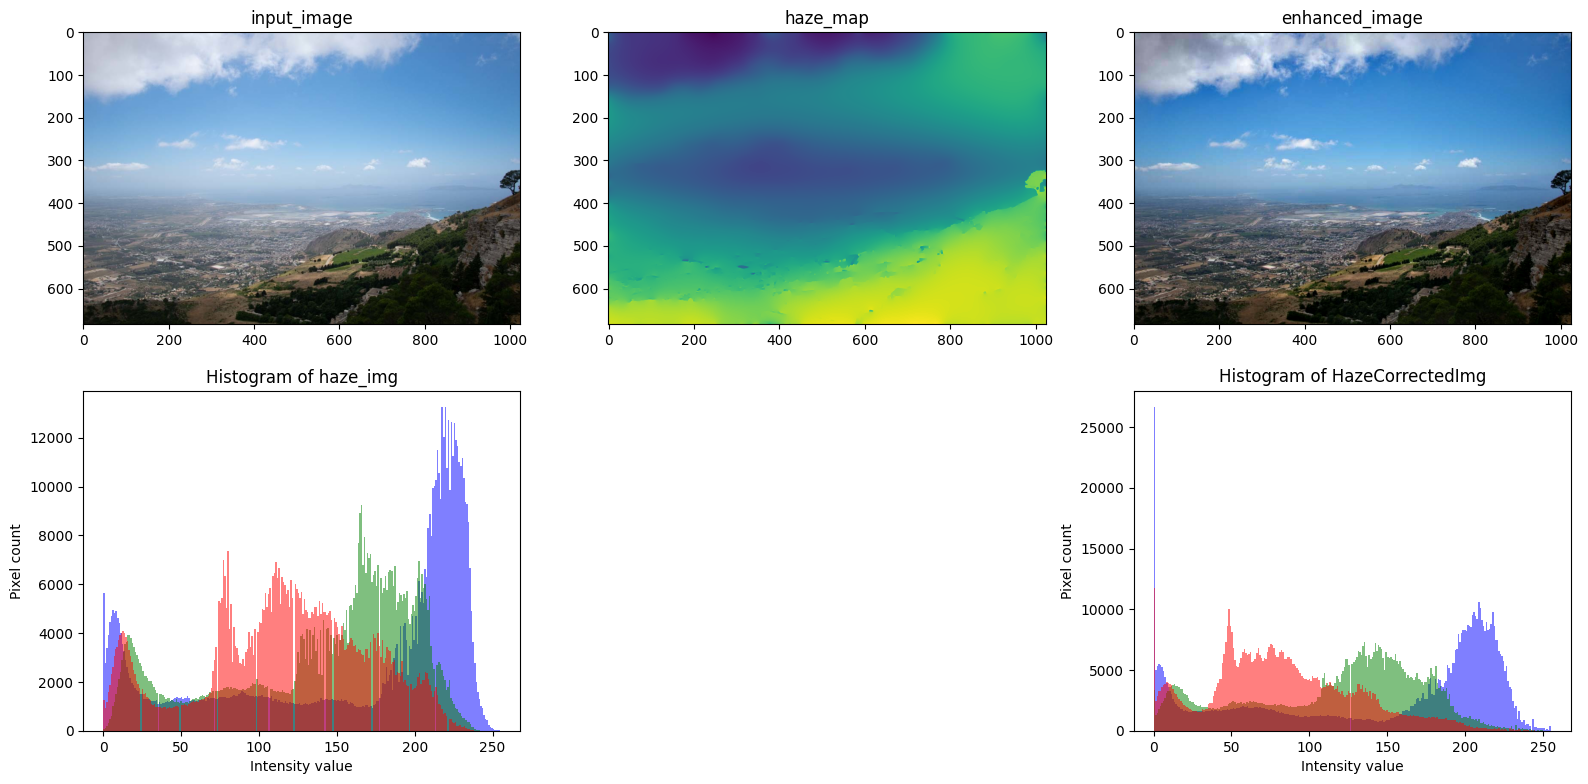

True

In [48]:
import cv2
import matplotlib.pyplot as plt

def plot_histogram(image, title, position):
    b, g, r = cv2.split(image)
    plt.subplot(2, 3, position)
    plt.hist(b.ravel(), bins=256, color='blue', alpha=0.5)
    plt.hist(g.ravel(), bins=256, color='green', alpha=0.5)
    plt.hist(r.ravel(), bins=256, color='red', alpha=0.5)
    plt.xlabel('Intensity value')
    plt.ylabel('Pixel count')
    plt.title(title)

# Set the figure size
plt.figure(figsize=(16, 8))

plt.subplot(2, 3, 1)
plt.imshow(cv2.cvtColor(haze_img3, cv2.COLOR_BGR2RGB))
plt.title('input_image')

plot_histogram(haze_img3, 'Histogram of haze_img', 4)

plt.subplot(2, 3, 2)
plt.imshow(haze_map3)
plt.title('haze_map')

plt.subplot(2, 3, 3)
plt.imshow(cv2.cvtColor(HazeCorrectedImg3, cv2.COLOR_BGR2RGB))
plt.title('enhanced_image')

plot_histogram(HazeCorrectedImg3, 'Histogram of HazeCorrectedImg', 6)

plt.tight_layout()
plt.show()

cv2.imwrite("/content/output/dehazed3.png", HazeCorrectedImg3)

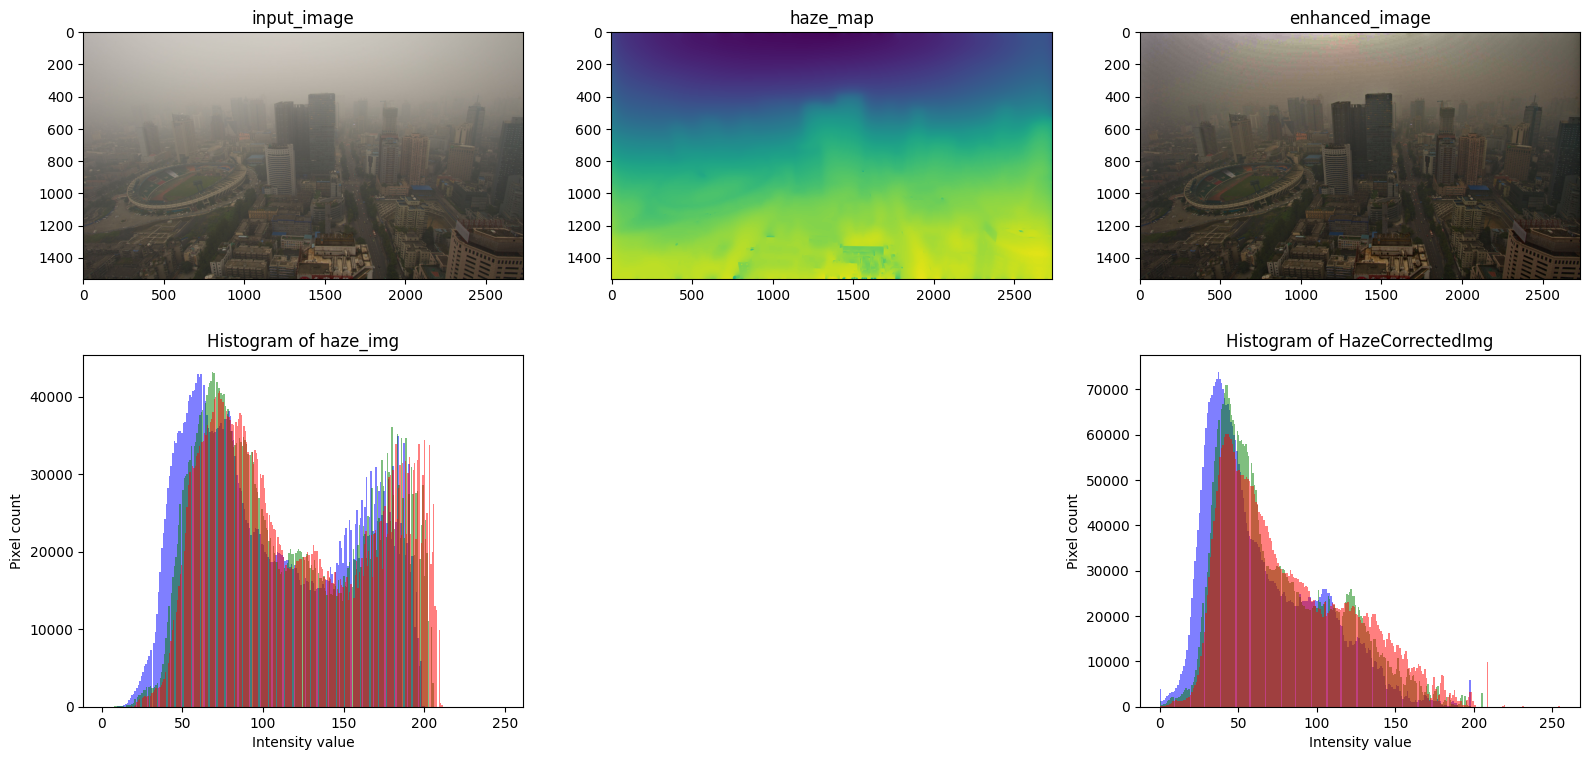

In [64]:
# Set the figure size
plt.figure(figsize=(16, 8))

plt.subplot(2, 3, 1)
plt.imshow(cv2.cvtColor(haze_img1, cv2.COLOR_BGR2RGB))
plt.title('input_image')

plot_histogram(haze_img1, 'Histogram of haze_img', 4)

plt.subplot(2, 3, 2)
plt.imshow(haze_map1)
plt.title('haze_map')

plt.subplot(2, 3, 3)
plt.imshow(cv2.cvtColor(HazeCorrectedImg1, cv2.COLOR_BGR2RGB))
plt.title('enhanced_image')

plot_histogram(HazeCorrectedImg1, 'Histogram of HazeCorrectedImg', 6)

plt.tight_layout()
plt.show()

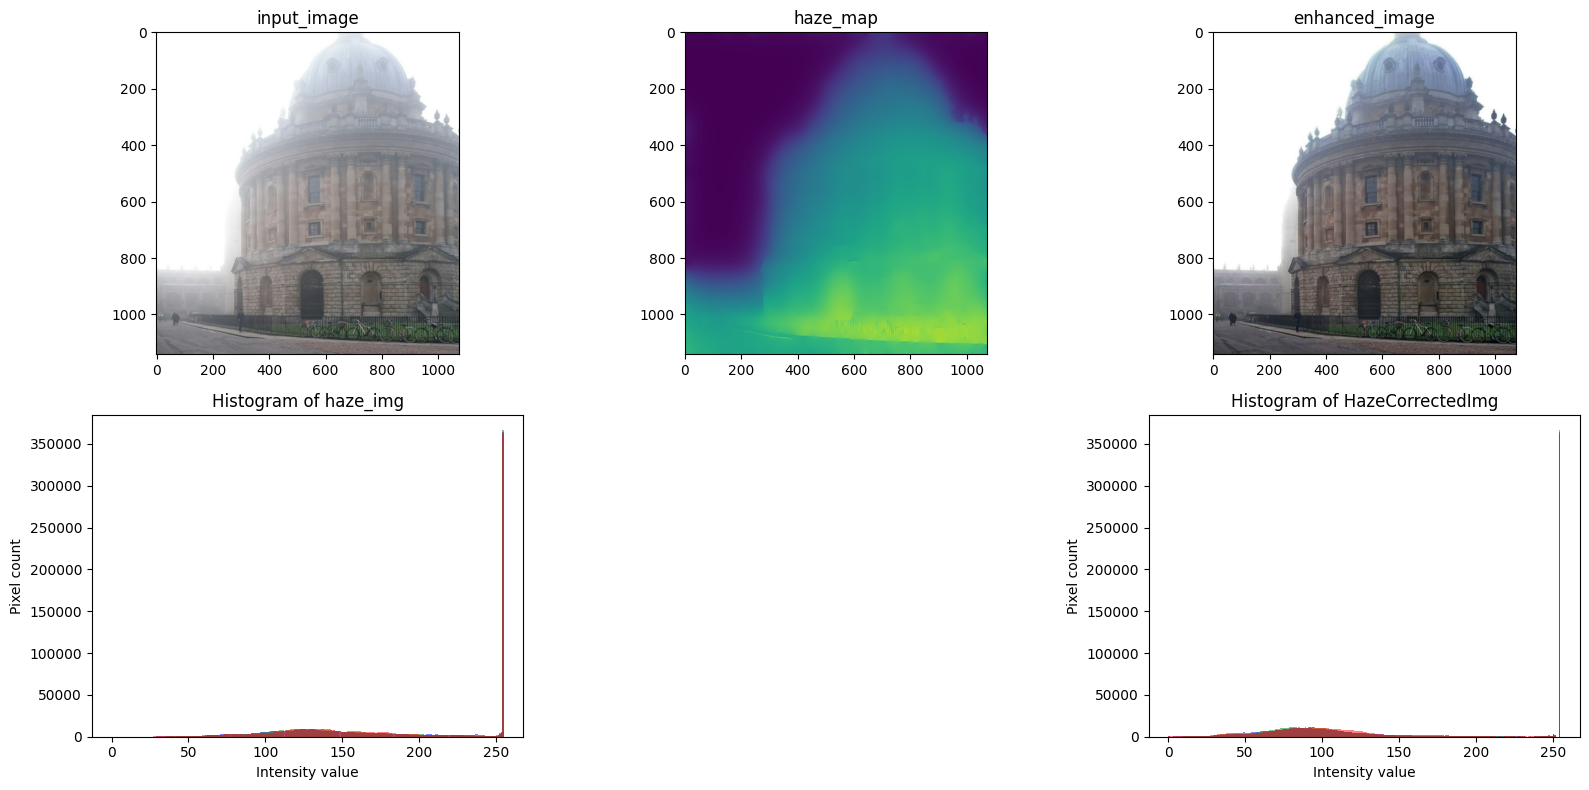

In [50]:
 # Set the figure size
plt.figure(figsize=(16, 8))

plt.subplot(2, 3, 1)
plt.imshow(cv2.cvtColor(haze_img2, cv2.COLOR_BGR2RGB))
plt.title('input_image')

plot_histogram(haze_img2, 'Histogram of haze_img', 4)

plt.subplot(2, 3, 2)
plt.imshow(haze_map2)
plt.title('haze_map')

plt.subplot(2, 3, 3)
plt.imshow(cv2.cvtColor(HazeCorrectedImg2, cv2.COLOR_BGR2RGB))
plt.title('enhanced_image')

plot_histogram(HazeCorrectedImg2, 'Histogram of HazeCorrectedImg', 6)

plt.tight_layout()
plt.show()

In [17]:
import cv2
import numpy as np
import os

def apply_clear_view(haze_img, delta):
    A = airlight_estimation(haze_img, window_size)
    transmission = bound_con(haze_img, A, C0, C1, window_size=boundaryConstraint_windowSze)
    t = cal_transmission(haze_img, transmission, regularize_lambda=regularize_lambda)
    haze_corrected_img = remove_haze(haze_img, t, A, delta=delta)
    return haze_corrected_img

# Set parameters
window_size = 15
boundaryConstraint_windowSze = 3
C0 = 20
C1 = 300
regularize_lambda = 0.1
delta_step = 0.05

# Load the input image
haze_img = cv2.imread('/content/what-is-haze.jpg')

# Generate the frames
frames = []
for delta in np.arange(0, 1 + delta_step, delta_step):
    haze_corrected_img = apply_clear_view(haze_img, delta)
    frames.append(haze_corrected_img)

# Save the frames as individual images
os.makedirs('frames', exist_ok=True)
for i, frame in enumerate(frames):
    cv2.imwrite(f'frames/frame_{i:03d}.png', frame)

# Combine the frames into a video
fourcc = cv2.VideoWriter_fourcc(*'XVID')
height, width, _ = haze_img.shape
out = cv2.VideoWriter('transformation_video.avi', fourcc, 10.0, (width, height))

for frame_path in sorted(os.listdir('frames')):
    frame = cv2.imread(os.path.join('frames', frame_path))
    out.write(frame)

out.release()


### Effect on a portrait : 

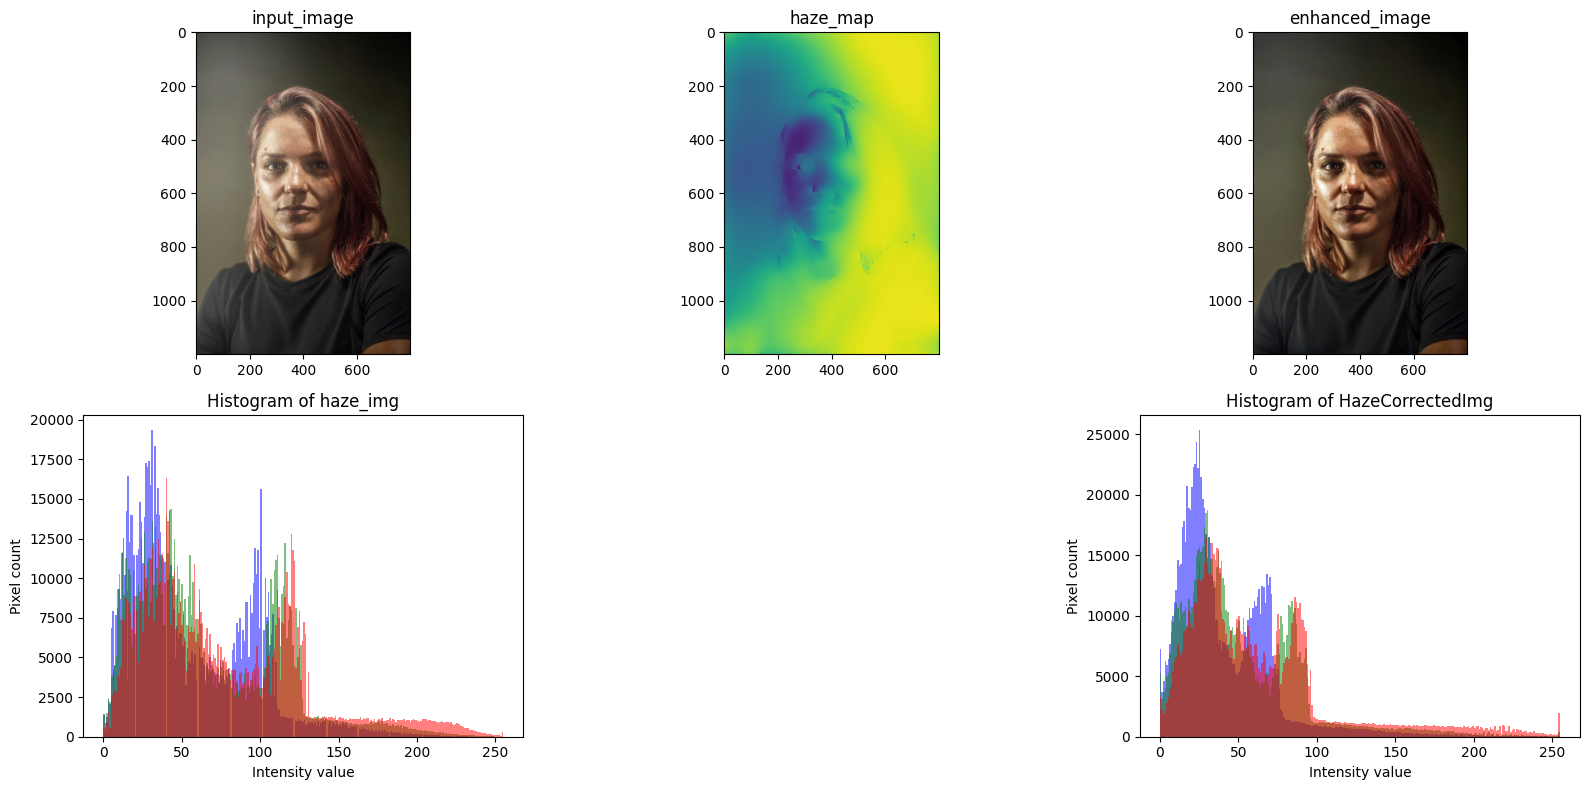

In [81]:
haze_img4 = cv2.imread('portrait.png')	
HazeCorrectedImg4, haze_map4 = apply_clear_view(haze_img4,delta=0.5)
# Set the figure size
plt.figure(figsize=(16, 8))

plt.subplot(2, 3, 1)
plt.imshow(cv2.cvtColor(haze_img4, cv2.COLOR_BGR2RGB))
plt.title('input_image')

plot_histogram(haze_img4, 'Histogram of haze_img', 4)

plt.subplot(2, 3, 2)
plt.imshow(haze_map4)
plt.title('haze_map')

plt.subplot(2, 3, 3)
plt.imshow(cv2.cvtColor(HazeCorrectedImg4, cv2.COLOR_BGR2RGB))
plt.title('enhanced_image')

plot_histogram(HazeCorrectedImg4, 'Histogram of HazeCorrectedImg', 6)

plt.tight_layout()
plt.show()

In [84]:
cv2.imwrite("/content/output/dehazed4.png", HazeCorrectedImg4)

True

**better comparaion**:

Text(0.5, 1.0, 'enhanced_image')

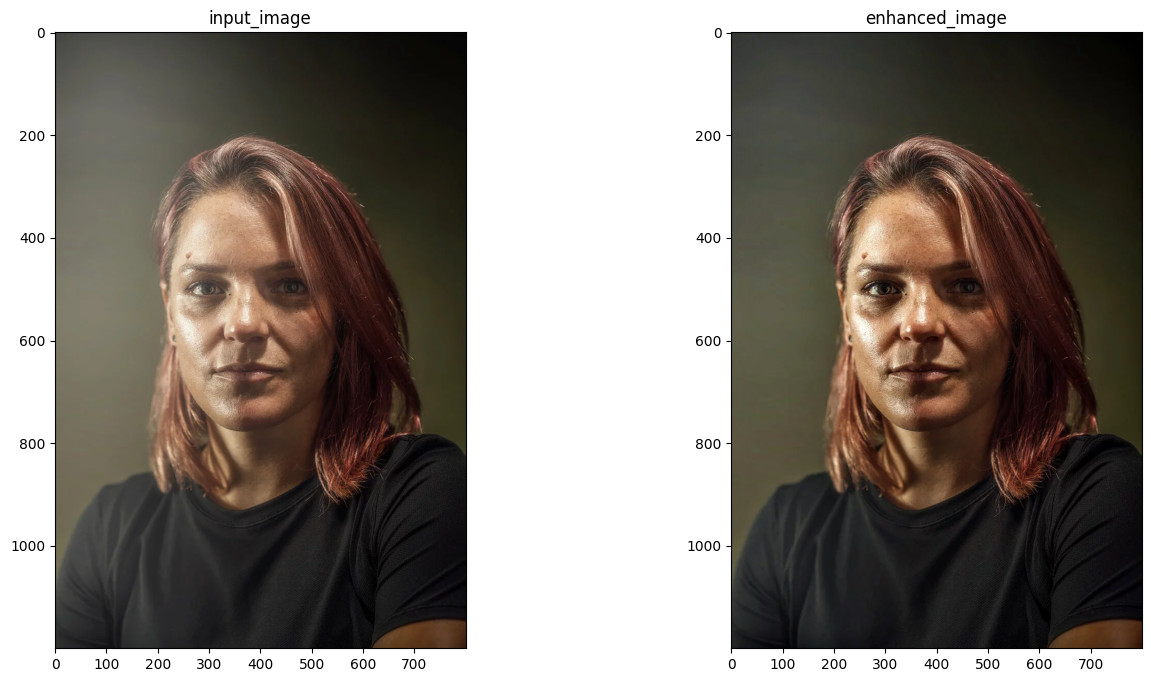

In [83]:
# Set the figure size
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(haze_img4, cv2.COLOR_BGR2RGB))
plt.title('input_image')

 

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(HazeCorrectedImg4, cv2.COLOR_BGR2RGB))
plt.title('enhanced_image')

 



## Studying the effect of different the most important parameter i.e. delta: 

In [ ]:
# Set parameters
window_size = 15
boundaryConstraint_windowSze = 3
C0 = 20
C1 = 300
regularize_lambda = 0.1
delta_step = 0.02

# Load the input image
haze_img = cv2.imread('/content/what-is-haze.jpg')
# Generate the frames
frames = []
for delta in np.arange(0, 1 + delta_step, delta_step):
    haze_corrected_img, _ = apply_clear_view(haze_img, delta)
    
    # Write delta value on the top left corner of the image
    text = f'Delta: {delta:.2f}'
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1.5
    font_color = (0, 0, 255)
    font_thickness = 3
    cv2.putText(haze_corrected_img, text, (10, 60), font, font_scale, font_color, font_thickness)
    
    frames.append(haze_corrected_img)

# Save the frames as individual images
os.makedirs('frames', exist_ok=True)
for i, frame in enumerate(frames):
    cv2.imwrite(f'frames/frame_{i:03d}.png', frame)

# Combine the frames into a video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
height, width, _ = haze_img.shape
out = cv2.VideoWriter('transformation_video.mp4', fourcc, 10.0, (width, height))

for frame_path in sorted(os.listdir('frames')):
    frame = cv2.imread(os.path.join('frames', frame_path))
    out.write(frame)

out.release()

In [77]:
import imageio

reader = imageio.get_reader('transformation_video.mp4')
fps = reader.get_meta_data()['fps']
writer = imageio.get_writer('transformation_video_ready.mp4', fps=fps)

for frame in reader:
    writer.append_data(frame)

writer.close()

In [79]:
from IPython.display import HTML
from base64 import b64encode

# Read the generated mp4 video
video = open('transformation_video_ready.mp4', 'rb').read()

# Encode the video in base64 format
video_encoded = b64encode(video).decode()

# Create the HTML code to display the video
html_code = f"""
<video controls width="880" height="560" autoplay loop>
  <source src="data:video/mp4;base64,{video_encoded}" type="video/mp4">
</video>
"""

# Display the HTML code
HTML(html_code)

In [93]:
# Set parameters
window_size = 15
boundaryConstraint_windowSze = 3
C0 = 20
C1 = 300
regularize_lambda = 0.1
delta_step = 0.02

# Load the input image
haze_img = cv2.imread('/content/portrait.png')
# Generate the frames
frames = []
for delta in np.arange(0, 1 + delta_step, delta_step):
    haze_corrected_img, _ = apply_clear_view(haze_img, delta)
    
    # Write delta value on the top left corner of the image
    text = f'Delta: {delta:.2f}'
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1.5
    font_color = (0, 0, 255)
    font_thickness = 3
    cv2.putText(haze_corrected_img, text, (10, 60), font, font_scale, font_color, font_thickness)
    
    frames.append(haze_corrected_img)

# Save the frames as individual images
os.makedirs('frames', exist_ok=True)
for i, frame in enumerate(frames):
    cv2.imwrite(f'frames/pframe_{i:03d}.png', frame)

# Combine the frames into a video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
height, width, _ = haze_img.shape
out = cv2.VideoWriter('portrait_transformation_video.mp4', fourcc, 10.0, (width, height))

for frame_path in sorted(os.listdir('frames')):
    frame = cv2.imread(os.path.join('frames', frame_path))
    out.write(frame)

out.release()

In [94]:
import imageio

reader = imageio.get_reader('portrait_transformation_video.mp4')
fps = reader.get_meta_data()['fps']
writer = imageio.get_writer('portrait_transformation_video_ready.mp4', fps=fps)

for frame in reader:
    writer.append_data(frame)

writer.close()

In [96]:
# Read the generated mp4 video
video = open('portrait_transformation_video_ready.mp4', 'rb').read()

# Encode the video in base64 format
video_encoded = b64encode(video).decode()

# Create the HTML code to display the video
html_code = f"""
<video controls width="880" height="560" autoplay loop>
  <source src="data:video/mp4;base64,{video_encoded}" type="video/mp4">
</video>
"""

# Display the HTML code
HTML(html_code)